# Importing the required Libraries

In [4]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import load_model
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

# Defining some Constants which will be used later in the project

In [2]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Preparing Training Data from the train folder

In [104]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [105]:
df.head()

,filename,category
0,cat.1.jpg,0
1,cat.10.jpg,0
2,cat.100.jpg,0
3,cat.1000.jpg,0
4,cat.10000.jpg,0


In [106]:
df.tail()

,filename,category
19995,dog.9993.jpg,1
19996,dog.9994.jpg,1
19997,dog.9995.jpg,1
19998,dog.9997.jpg,1
19999,dog.9998.jpg,1


### Let's see the total value counts of each class

<AxesSubplot:>

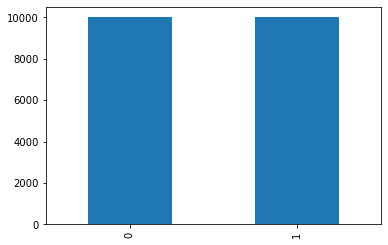

In [107]:
df['category'].value_counts().plot.bar()

From our data we have 10000 cats images and 10000 dogs images

# Let's see random sample image from dataset

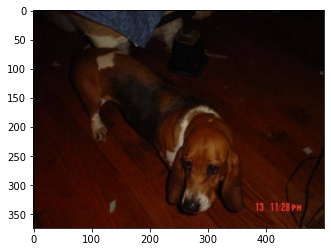

In [108]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

# Layers of our CNN model

* **Input Layer**: It represents the input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert it to (4096,1) array.
* **Conv Layer**: This layer will extract the features from image.
* **Pooling Layer**: This layer will reduce the spatial volume of the input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer, in our case the output is cat or dog. 

In [109]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 61, 61, 64)      

# Defining the Callbacks

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs if val_loss value does not decrease

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy does not increase for 2 steps

In [110]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# Preparing the  data

In [111]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [112]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

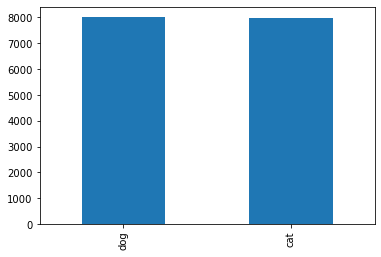

In [113]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

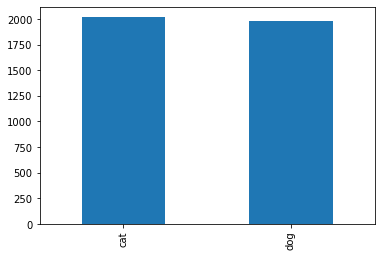

In [114]:
validate_df['category'].value_counts().plot.bar()

In [115]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Training Generator

In [116]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 16000 validated image filenames belonging to 2 classes.


## Validation Generator

In [117]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4000 validated image filenames belonging to 2 classes.


# Let's see how our generator works with an example

In [118]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


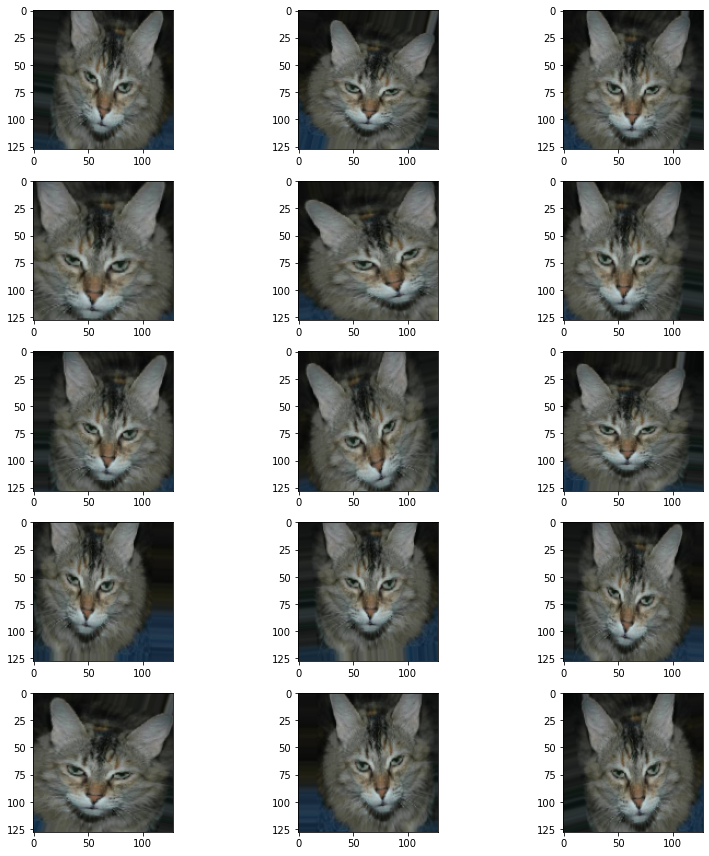

In [119]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Model Training

In [120]:
epochs=3 if FAST_RUN else 25
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

Epoch 1/25
1066/1066 [==============================] - 506s 473ms/step - loss: 0.7748 - accuracy: 0.6246 - val_loss: 0.5481 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 2/25
1066/1066 [==============================] - 471s 442ms/step - loss: 0.5711 - accuracy: 0.7091 - val_loss: 0.4690 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 3/25
1066/1066 [==============================] - 468s 439ms/step - loss: 0.5198 - accuracy: 0.7503 - val_loss: 0.4892 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 4/25
1066/1066 [==============================] - 468s 439ms/step - loss: 0.4817 - accuracy: 0.7724 - val_loss: 0.4496 - val_accuracy: 0.7995 - lr: 0.0010
Epoch 5/25
1066/1066 [==============================] - 469s 440ms/step - loss: 0.4591 - accuracy: 0.7917 - val_loss: 0.5737 - val_accuracy: 0.7546 - lr: 0.0010
Epoch 6/25
1066/1066 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.7956
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1066/1066 [==========

# Visualize Training

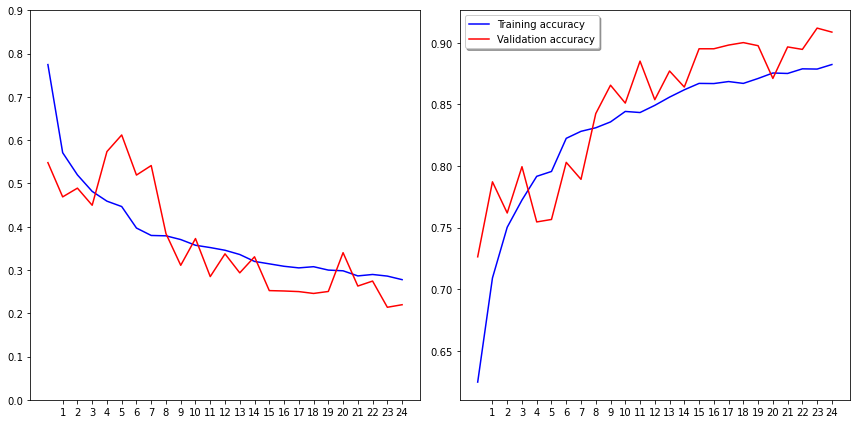

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Classifying cat and dog images using our trained model

In [8]:
## note the results={
##     0='cat',
##     1='dog'
## }
# uncomment the following 2 lines if you just want to try the prediction right here on jupyter-notebook and dont want to train the model from scratch
# model = load_model("model.h5")
# IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
from PIL import Image
import numpy as np
filepath = str(input("Paste the full path of the image you want to test with the extension : "))
filepath = filepath.replace("/", "\\")
im=Image.open(filepath)
im=im.resize(IMAGE_SIZE)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]
print("\nProbability of Cat vs Dog :",pred,"\n\nPrediction (0=cat,1=dog) : ",np.argmax(pred))
if(pred[0]<0.7 and pred[0]>0.5):
    print("It is probably a cat")
elif(pred[1]<0.7 and pred[1]>0.5):
    print("It is probably a dog")
elif np.argmax(pred):
    print("It is a dog")
else:
    print("It is a cat")

Paste the full path of the image you want to test with the extension : D:\CatAndDogDataset\dog-cat-full-dataset\data\test\dogs\dog.274.jpg
1/1 [==============================] - 0s 17ms/step

Probability of Cat vs Dog : [0.3999661  0.60003394] 

Prediction (0=cat,1=dog) :  1
It is probably a dog
